## Multiclass classification  


In [2]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

In [3]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [4]:
batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              batch_size, shuffle=False)


In [5]:
net = gluon.nn.Dense(num_outputs)

In [6]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

In [7]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [8]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [9]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [10]:
evaluate_accuracy(test_data, net)

0.0774

In [11]:
epochs = 10
moving_loss = 0.

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()

    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 2.1415544213612874, Train_acc 0.7918833333333334, Test_acc 0.8015
Epoch 1. Loss: 0.9146347909927368, Train_acc 0.8340666666666666, Test_acc 0.8429
Epoch 2. Loss: 0.7468763765970866, Train_acc 0.8524333333333334, Test_acc 0.861
Epoch 3. Loss: 0.65964135333697, Train_acc 0.8633333333333333, Test_acc 0.8696
Epoch 4. Loss: 0.6039828490893046, Train_acc 0.8695833333333334, Test_acc 0.8753
Epoch 5. Loss: 0.5642358363191287, Train_acc 0.8760166666666667, Test_acc 0.8819
Epoch 6. Loss: 0.5329904221892356, Train_acc 0.8797, Test_acc 0.8849
Epoch 7. Loss: 0.5082313110192617, Train_acc 0.8842166666666667, Test_acc 0.8866
Epoch 8. Loss: 0.4875676867882411, Train_acc 0.8860333333333333, Test_acc 0.8891
Epoch 9. Loss: 0.47050906361341477, Train_acc 0.8895333333333333, Test_acc 0.8902


(10, 28, 28, 1)


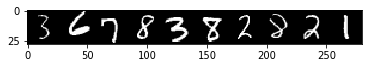

model predictions are: 
[3. 6. 7. 8. 3. 8. 1. 8. 2. 1.]
<NDArray 10 @cpu(0)>


In [13]:
import matplotlib.pyplot as plt

def model_predict(net,data):
    output = net(data.as_in_context(model_ctx))
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break